# Introduction to Darts
In this notebook, we go over some of the keys functionalities of the library:

* [Basics about the TimeSeries](#Building-and-manipulating-TimeSeries)
* [Training forecasting models and making predictions](#Training-forecasting-models-and-making-predictions)
* [Covariates: using external data](#Covariates:-using-external-data)
* [Probabilistic forecasts](#Probabilistic-forecasts)
* [Backtesting and Residuals](#Backtesting-and-Residuals)

We will only show some minimal "get started" examples here. For more in depth information, you can refer to our [user guide](https://unit8co.github.io/darts/userguide.html) and [example notebooks](https://unit8co.github.io/darts/examples.html).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts.models import (
    LinearRegressionModel,
    LightGBMModel,
    XGBModel,
)
from darts.metrics import mape
from darts.datasets import ElectricityConsumptionZurichDataset
from darts.utils.statistics import plot_residuals_analysis

/Users/antoinemadrona/code/darts/.venv/darts/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


# Building and manipulating `TimeSeries`
`TimeSeries` is the main data class in Darts. A `TimeSeries` represents a univariate or multivariate time series, with a proper time index. The time index can either be of type `pandas.DatetimeIndex` (containing datetimes), or of type `pandas.RangeIndex` (containing integers; useful for representing sequential data without specific timestamps). In some cases, `TimeSeries` can even represent *probabilistic* series, in order for instance to obtain confidence intervals. All models in Darts consume `TimeSeries` and produce `TimeSeries`.

## Read data and build a `TimeSeries`
`TimeSeries` can be built easily using a few factory methods:

* From an entire Pandas `DataFrame`, using `TimeSeries.from_dataframe()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_dataframe)).
* From a time index and an array of corresponding values, using `TimeSeries.from_times_and_values()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_times_and_values)).
* From a NumPy array of values, using `TimeSeries.from_values()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_values)).
* From a CSV file, using `TimeSeries.from_csv()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_csv)).
* and more...

Below, we get a `TimeSeries` by directly loading the Zurich's electricity consumption series from one of the datasets available in Darts:


In [2]:
ts_energy = ElectricityConsumptionZurichDataset().load()

Technical information about this dataset:

**Frequency**
quarter-hourly (15 Minutes time intervals), but resampled to hourly for the sake of simplicity.

**Target series** (the series we want to forecast):
- **Value_NE5**: Electricity consumption by households on grid level 5 (in kWh).

**Covariates** (external data to help improve forecasts):
The dataset also comes with weather measurements that we can use as covariates. For simplicity, we use:
- **T [°C]**: Measured temperature
- **StrGlo [W/m2]**: Measured solar irradation
- **RainDur [min]**: Measured raining duration

The `TimeSeries` can then easily be manipulated to extract the desired time range and dimensions:

/Users/antoinemadrona/code/darts/.venv/darts/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


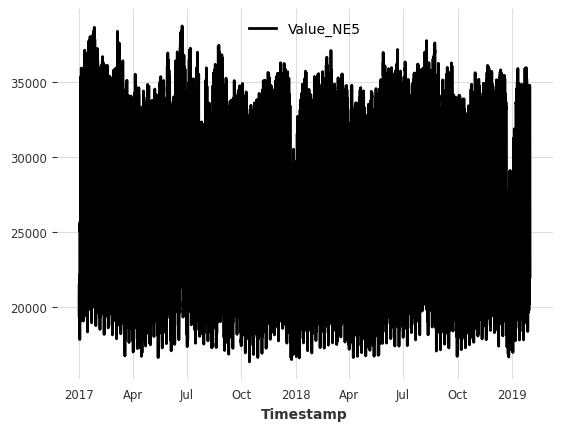

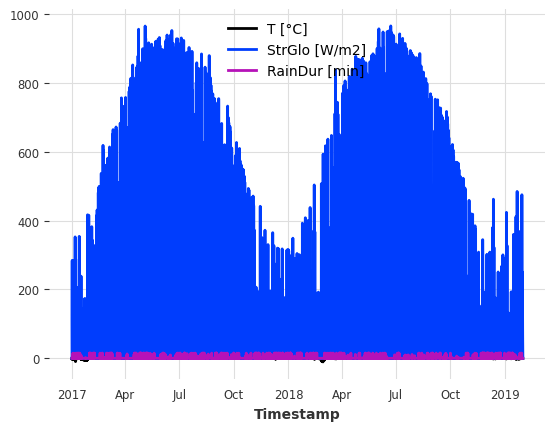

In [3]:
# extract values recorded between 2017 and 2019
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2019-01-31")
ts_energy = ts_energy[start_date:end_date]

# resample to hourly frequency
ts_energy = ts_energy.resample(freq="H")

# extract temperature, solar irradiation and rain duration
ts_weather = ts_energy[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]

# extract households energy consumption
ts_energy = ts_energy["Value_NE5"]

# create train and validation splits
validation_cutoff = pd.Timestamp("2018-10-31")
ts_energy_train, ts_energy_val = ts_energy.split_after(validation_cutoff)

# vizualize the series
ts_energy.plot()
plt.show()

ts_weather.plot()
plt.show()

# Training forecasting models and making predictions

Darts offers a unified API for simple statistical models such as `ARIMA` to `Regression Models` and  decision trees-based methods like `LightGBM` or `GXBoost` but also state-of-the art deep learning models such as `TiDE`, `DLinear` or `TSMixer`, which are regularly implemented in the library.

For the sake of simplicity, let's focus on `Regression Models`;

In Darts, the forecasting problem is translated into a regression problem by converting the time series into two tabular arrays:
- `X`: features or input array with the shape (number of samples/observations, number of features)
  - The number of features is given by the total number of (feature specific) target, past, and future covariates lags.
- `y`: target or label array with the shape (number of samples/observations, number of targets)
  - The number of targets is given by the model parameters `output_chunk_length` and `multi_models` (we'll explain this later on).

### Target and covariates lags

A lagged feature is the value of a feature at a previous or future time step compared to some reference point. 

In Darts, the value of the lag specifies the position of the feature value relative to the first predicted target time step `y_t0` for each observation/sample (a row in `X`).

- `lag == 0`: position of the first predicted time step `t0`, e.g. position of `y_t0`
- `lag < 0`: all positions in the past of the first predicted time step `t-1`, `t-2`, ...
- `lag > 0`: all positions in the future of the first predicted time step `t+1`, `t+2`, ...

The choice of lags is critical in achieving good predictive accuracy. We want the model to receive relevant information to capture the temporal properties/dependencies our target series (patterns, seasonalities, trends, ...). It also has a considerable impact on the model performance/complexity, as each additional lag adds a new feature to `X`.

At model creation, we can set lags for the target and the covariates series separately.

- `lags`: lags for the target series (the one we want to forecast)
- `lags_past_covariates`: optionally, lags for a past covariates series (external past-observed features to help improve forecasts)
- `lags_future_covariates`: optionally, lags for a future covariates series (external future-known features to help improve forecasts)

There are multiple ways to define your lags `(int, List[int], Tuple[int, int], ...)`. You can find out more about this in the [RegressionModel docs](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html#darts.models.forecasting.regression_model.RegressionModel).

### Lagged data extraction
Now, let's have a look at how `X` and `y` is extracted for training using the scenario from below:

- `lags=[-4,-3,-2,-1]`: use the last 4 target values (green) before the first predicted time step (orange) as `X` features.
- `output_chunk_length=1`: predict the target value `y` of next (`1`) time step (orange).
- we have a target series with 7 time steps `t_i, ..., t_i+6` (blue).

*Note: This example only shows target `lags` extraction, but the same is applied to `lags_past/future_covariates`.*

![forecast_single_model_ocl3](./images/regression_model_train.png)

### Examples
Let's try to apply this to our electricity dataset. Assume, we want to predict the consumption of the next couple of hours after the end of our training set. 

As input features we give it the consumption at the same hour from one and two days ago -> `lags=[-24, -48]`.

<Axes: xlabel='Timestamp'>

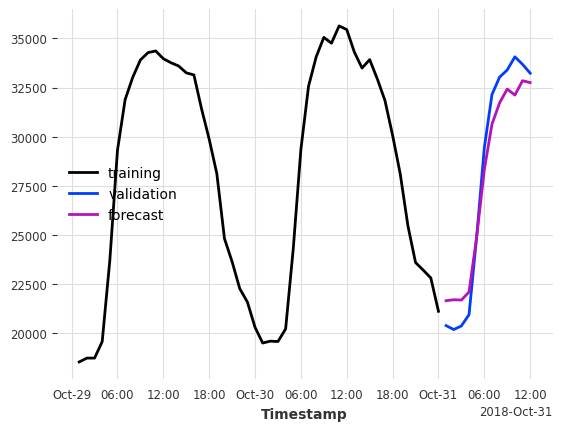

In [4]:
model = LinearRegressionModel(lags=[-24, -48])
model.fit(ts_energy_train)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

### Covariates: using external data

To improve the quality of the forecasts, it is possible to provide external information to the model ; they are called `covariates` in Darts.

![covariates-illustration](./images/covariates-highlevel.png)

To use external data next to the history of our target series, we specify past and/or future covariates lags and then pass `past_covariates` and/or `future_covariates` to `fit()` and `predict()`.

Let's assume that instead of having weather measurements, we actually have weather forecasts. Then we could use them as future_covariates. **We only do this here for demonstration purposes!**

Below is an example that uses the last 24 hours (`24`) from hour target series (electricity consumption) and the values at the predicted time step (`[0]`) of our weather "forecasts".

<Axes: xlabel='Timestamp'>

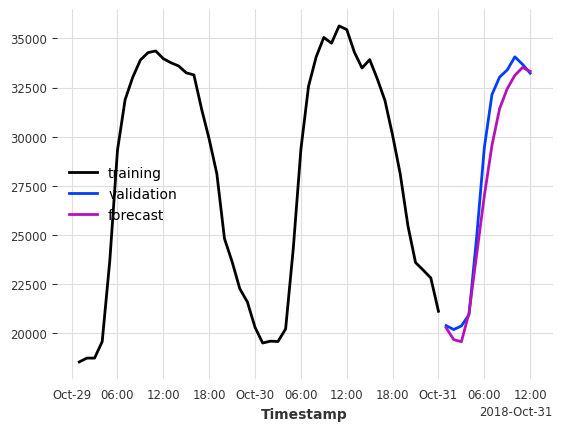

In [5]:
model = LinearRegressionModel(lags=24, lags_future_covariates=[0])
model.fit(ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

### Using only covariates as features/predictors

Sometimes, we might also be interested in a forecasting model that purely relies on the covariates values.

To do this, specify at least one of `lags_past_covariates` or `lags_future_covariates` and set `lags=None`. 
Darts regression models are trained in a supervised manner, so we still have to provide the target series for training but it'll not be accessed during inference.

How well can we predict the electricity consumption using only the weather "forecasts" as input?

The lags tuple `(24, 1)` means (number of lags in the past, number of lags in the future).

<Axes: xlabel='Timestamp'>

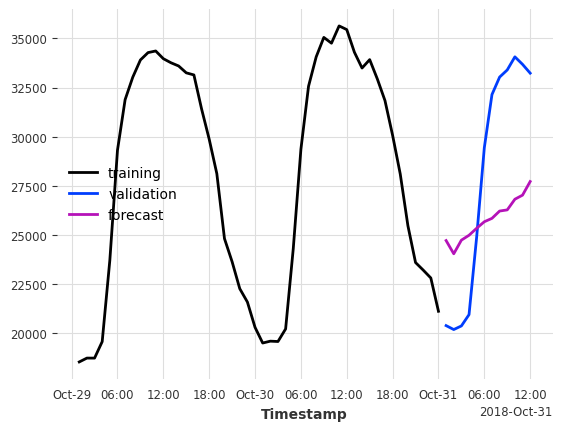

In [6]:
model = LinearRegressionModel(lags=None, lags_future_covariates=(24, 1))
model.fit(series=ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

### Model's output chunk length

This key parameter sets the *number of time steps that can be predicted at once by the internal regression model*.

It is not the same as forecast horizon `n` from `predict()` which is the **desired** the number of generated prediction points, that is achieved either with:
- a single shot forecast (if `n <= output_chunk_length`), or
- an auto-regressive forecast, consuming its own forecast (and future values of covariates) as input for additional predictions (otherwise)

For example, if we want our model to forecast the next 24 hours of electricity consumption based on the last day of consumption, setting `output_chunk_length=24` ensures that the model will not consume its forecasts or future values of our covariates to predict the entire day.

<Axes: xlabel='Timestamp'>

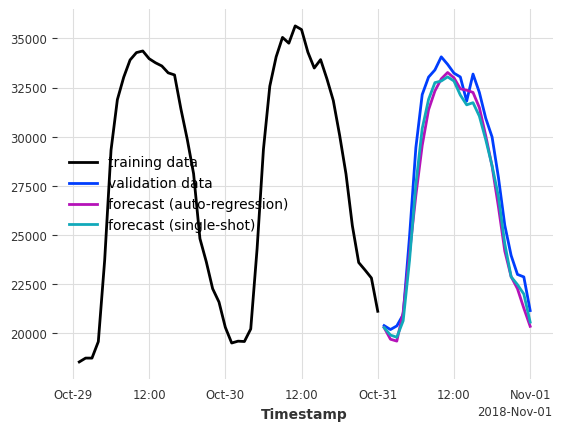

In [7]:
model_auto_regression = LinearRegressionModel(lags=24, output_chunk_length=1)
model_single_shot = LinearRegressionModel(lags=24, output_chunk_length=24)

model_auto_regression.fit(ts_energy_train)
model_single_shot.fit(ts_energy_train)

pred_auto_regression = model_auto_regression.predict(24)
pred_single_shot = model_single_shot.predict(24)

ts_energy_train[-48:].plot(label="training data")
ts_energy_val[:24].plot(label="validation data")
pred_auto_regression.plot(label="forecast (auto-regression)")
pred_single_shot.plot(label="forecast (single-shot)")

### Multi-model forecasting
When `output_chunk_length>1`, the model behavior can be further parametrized by modifying the `multi_models` argument.

`multi_models=True` is the default behavior in Darts and was shown above. We create `output_chunk_length` copies of the model, and train each of them to predict one of the `output_chunk_length` time steps (using the same inputs). 
This approach is more computationally and memory intensive but tends to yield better results.

### Single-model forecasting
When `multi_model=False`, we use a single model and train it to predict only the last point in `output_chunk_length`. This reduces model complexity as only a single set of coefficients will be trained and stored.

We are still able to predict all points from 1 until `output_chunk_length` by shifting the lags during tabularization.
This means that a new set of input values is used for each forecasted value. Due to the shifting, the minimum length requirement for the training series will also be increased.

### Probabilistic forecasting

To make a model probablistic, set parameter `likelihood` to `quantile` or `poisson` when creating a `RegressionModel`. At prediction time, probabilistic models can either :
- use Monte Carlo sampling to generate samples based on the fitted distribution parameters when `num_samples > 1`
- return the fitted distribution parameters when `predict_likelihood_parameters=True`

Note that when using the `quantile` regressor, each quantile will be fitted by a different model.

Probabilistic models will generate different forecasts each time `predict()` is called with `num_samples > 1`. To get reproducible results, set the random seed when creating the model and call the methods in the exact same order.

Value_NE5_q0.05 : 19580.123046875
Value_NE5_q0.50 : 19623.302734375
Value_NE5_q0.95 : 20418.7421875


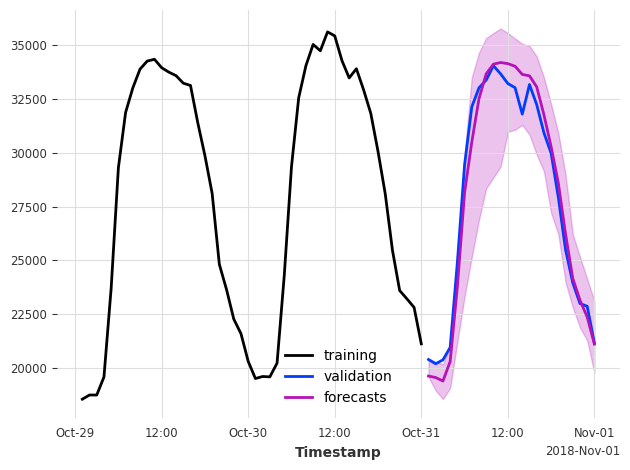

In [8]:
model = XGBModel(
    lags=24, output_chunk_length=1, likelihood="quantile", quantiles=[0.05, 0.5, 0.95]
)

model.fit(ts_energy_train)

pred_samples = model.predict(n=24, num_samples=200)
pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

for val, comp in zip(pred_params.values()[0], pred_params.components):
    print(f"{comp} : {round(val, 3)}")

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_samples.plot(label="forecasts")
plt.tight_layout()

## Backtesting and Residuals

So at this point, the models' performance on the validation set is known, which is great but not enough: it is necessary to also know which performance would these models would have reached if used historically?

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is (by default) re-trained every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a forecast horizon, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 24 hours in the future (compared to prediction time). The result of calling `historical_forecasts()` is (by default) a `TimeSeries` that contains all those 1-day ahead forecasts:

In [9]:
# use retrain=False to save time, ideally, the model should be retrained before each forecats
hf_single = model_single_shot.historical_forecasts(ts_energy, start=0.6, retrain=False, forecast_horizon=24, last_points_only=True)

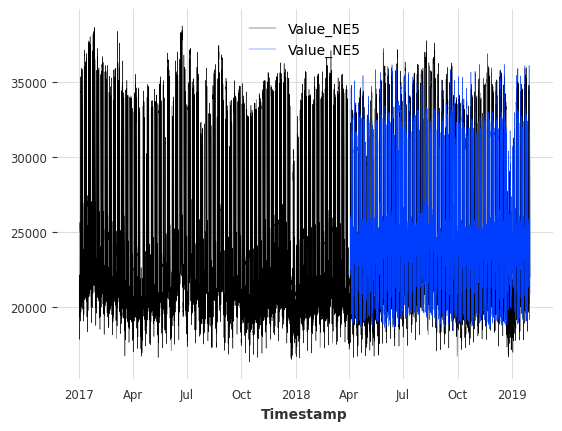

In [10]:
ts_energy.plot(lw=0.3)
hf_single.plot(lw=0.3)
plt.show()

In [11]:
# keeping each historical forecast instead of saving the last point of each.
hf = model_single_shot.historical_forecasts(ts_energy, start=0.6, retrain=False, forecast_horizon=24, last_points_only=False)
# reusing the historical forecasts obtained above
backtest_single = model_single_shot.backtest(ts_energy, historical_forecasts=hf, metric=mape)
print(f"Obtained a mape of {backtest_single} over the historical forecasts.")

Obtained a mape of 8.73855956271082 over the historical forecasts.


Now, let’s look at the fitted value residuals of one of the model, i.e. the difference between the 1-step forecasts at every point in time obtained by fitting the model on all previous points, and the actual observed values:

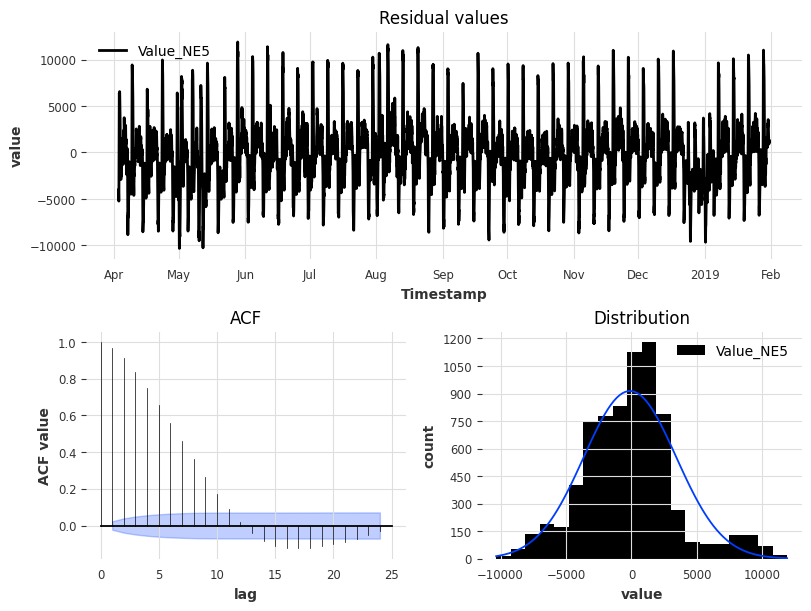

In [13]:
plot_residuals_analysis(model_single_shot.residuals(ts_energy, historical_forecasts=hf_single))

We can see that the distribution rather centered at 0, which means that the model is not biased. We can also make out a large ACF value at lags from 1 to 10 and 15 to 20, which indicates that the residuals contain information that was not used by the model.

## Conclusion

Darts offers a simple data-structure, the `TimeSeries`, to provide a lot of features as well as safeguards for ingestion and manipulation of timeseries.

By tabularizing the data and unifying the API across libraries, Darts closes the gap between traditional regression problems and timeseries forecasting, making it very easy to experiment and obtain forecasts in just a few lines of codes.